# Saved plots

100%|██████████| 20/20 [04:56<00:00, 24.17s/it]



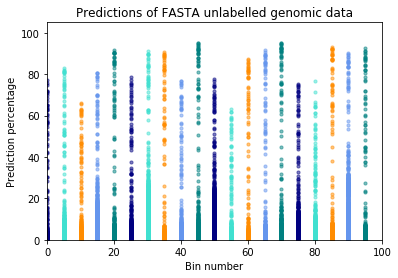

In [6]:
plot_predictions()
# 20 samples

100%|██████████| 150/150 [2:27:50<00:00, 91.72s/it]



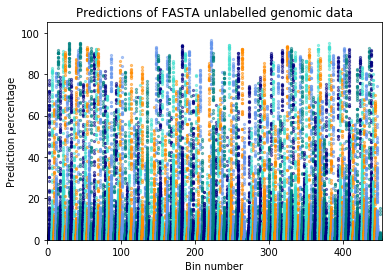

In [13]:
plot_predictions()
# Narrow spaced

100%|██████████| 150/150 [2:37:32<00:00, 129.25s/it]



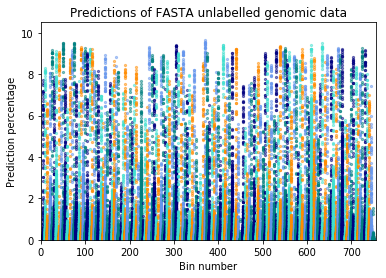

In [14]:
plot_predictions()
# Widely spaced

100%|██████████| 150/150 [2:35:46<00:00, 95.31s/it]



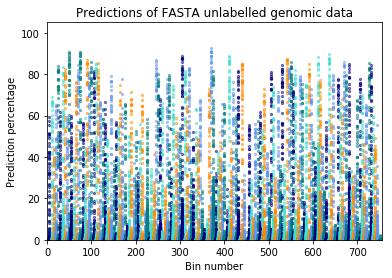

In [15]:
plot_predictions()
# Squared predictions

100%|██████████| 150/150 [00:00<00:00, 214.43it/s]



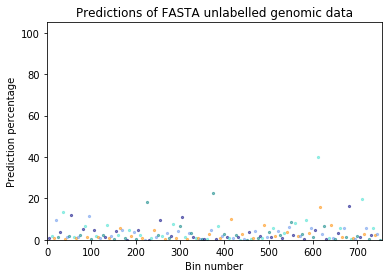

In [13]:
plot_predictions()

100%|██████████| 150/150 [00:00<00:00, 352.77it/s]



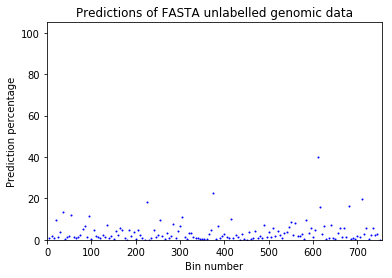

In [33]:
plot_predictions_sliding()

# Get File Structure

In [1]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# Load up the entries as environment variables
load_dotenv(dotenv_path)

# Get the directories of the project based off of '.env' which is in the root directory
ROOT_DIR = os.path.join(dotenv_path, os.pardir)
ROOT_DIR = dotenv_path[:-len('.env')] # Strip .env from dotenv_path to get root directory
SRC_DIR = ROOT_DIR + 'src/'

print('ROOT_DIR = {:s}'.format(ROOT_DIR))
print('SRC_DIR = {:s}'.format(SRC_DIR))

sys.path.append(os.path.normpath(ROOT_DIR))

ROOT_DIR = /home/minhoolee/Github/Synopsys-Project-2017/
SRC_DIR = /home/minhoolee/Github/Synopsys-Project-2017/src/


# Prediction Generator

In [5]:
import numpy as np
import h5py
import scipy.io
import time
import sys
import argparse

from os.path import isfile

from src.models.keras_model_utils import Model
from src.logging import log_utils

TRUNCATE_DATASET_RATIO = 0.5

_log = log_utils.logger(__name__)

def predict_and_save(argv):
    # Set up argument parsing
    parser = argparse.ArgumentParser(
        description='Test a Keras model on genetic sequences '
        + 'to derive epigenetic mechanisms')

    parser.add_argument('model_name', metavar='MODEL_NAME', help="The unique name of the model to create")
    parser.add_argument('fasta_file', metavar='FASTA_FILE', help="The file(valid FASTA) to open the raw data from")
    # parser.add_argument('create_fn', metavar='MODEL_FUNC', help="The name of the function in src/models/create_models to create a model with")
    parser.add_argument('weights_file', metavar='WEIGHTS_FILE', help="The file (.hdf5) to store the model's weights")
    parser.add_argument('json_file', metavar='JSON_FILE', help="The file (.json) to store the model's architecture in JSON")
    parser.add_argument('yaml_file', metavar='YAML_FILE', help="The file (.yaml) to store the model's architecture in YAML")
    parser.add_argument('log_file', metavar='LOG_FILE', help="The file (.csv) to store the model's epoch logs")
    parser.add_argument('tensorboard_dir', metavar='TB_DIR', help="The directory to store the model's tensorboard data (if using Tensorflow backend)")
    args = parser.parse_args(argv)

    data = FastaData(args.fasta_file)

    model = Model(name=args.model_name)
    print(args.json_file)
    model.load_from(json_file=args.json_file, yaml_file=args.yaml_file) # Temporary solution to running a model under a new name
    model.load_weights(weights_file=args.weights_file)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    _log.info('Retrieving test data...')
    test = data.get_unlabeled_prediction_data()

    log_utils.print_date_time(_log)
    start = time.time()

    # _log.info('Testing model...')
    # model.test(test=test)
    # log_utils.print_elapsed_time(_log, start=start, now=time.time())

    _log.info('Creating predictions...')
    y_predict = model.predict(test)

    dict = {}
    dict['predictions'] = np.array(y_predict)
    scipy.io.savemat(ROOT_DIR +'models/y_predict_' + args.model_name + '_PPARGC1A.mat', dict)

    log_utils.print_date_time(_log)

Using Theano backend.


In [ ]:
## model_name = 'conv_net_large_res_5'
argv= [model_name,
       ROOT_DIR + '/data/raw/PPARGC1A.fa',
       ROOT_DIR +'models/weights/'+model_name+'.hdf5', 
       ROOT_DIR +'models/json/'+model_name+'.json', 
       ROOT_DIR +'models/yaml/'+model_name+'.yaml', 
       ROOT_DIR +'models/csv/'+model_name+'.csv', 
       ROOT_DIR +'models/run_logs/tensorboard']
predict_and_save(argv)

## Execute all of the following

### FASTA Genome Data

In [5]:
from itertools import groupby
import itertools
import pandas as pd
import numpy as np

def one_hot_encode(l):
    """
    One hot encodes an one dimensional list into a numpy array
    """
    # Check if list is one dimensional, otherwise panda dataframes conversion will fail
    assert isinstance(l, list) == True
    assert isinstance(l[0], list) == False

    s = pd.Series(l)
    return (pd.get_dummies(s).values.tolist())
    

def _bin(l, start, stop, bin_size):
    """
    Bins a list (0 padded for incomplete lists)

    # Arguments:
        l:
            The list to bin
    """
    out = []
    for i in range(start, stop, bin_size):
        if i + bin_size < stop:
            out.append(l[i:i+bin_size])
        else:
            # 0 pad for incomplete bins
            rem = stop - i
            #out.append(l[i:stop] + [[0]*4]*(bin_size-rem))
            a = [l[i:stop], [[0]*4]*(bin_size-rem)]
            out.append(list(itertools.chain.from_iterable(a)))
    return out
        
class FastaData():
    def __init__(self, file_name=None):
        self.file_name = file_name
        self.headers = []
        self.seqs = []
        self.seq_lens = []
        self._populate()

    def iter(self):
        """
        https://www.biostars.org/p/710/

        Given a fasta file, yield tuples of header, sequence
        """
        fh = open(self.file_name)
        # ditch the boolean (x[0]) and just keep the header or sequence since
        # we know they alternate.
        faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

        for header in faiter:
            # drop the ">"
            headerStr = header.__next__()[1:].strip()
            seq = "".join(s.strip() for s in faiter.__next__())

            yield (headerStr, seq)
            
    def _populate(self):
        # Grab all valid FASTAs
        f = self.iter()
        for ff in f:
            h, s = ff
            self.headers.append(h)
            self.seqs.append(s)
            self.seq_lens.append(len(s))
    
    def _bin_seqs(self, bin_size):
        """
        Bins all the raw genomic sequences according to the bin size
        """
        #out = []
        #for k in range(len(self.seqs)):
        #    out.append(_bin(list(self.seqs[k]), 0, self.seq_lens[k], bin_size))
        #return out
        return _bin(one_hot_encode(list(self.seqs[0])), 0, self.seq_lens[0], bin_size)
    
    def get_unlabeled_prediction_data(self, bin_size=1000):
        """
        Returns genomic sequence in a numpy array of one hot encoded 
        bins (0 padded if bin is larger than sequence)
        Assume FASTA file can only contain one genomic sequence for now
        
        # Arguments:
            bin_size:
                Size of each bin 
        """
        #return one_hot_encode(self._bin_seqs(bin_size))
        return np.array(self._bin_seqs(bin_size))

In [6]:
f = FastaData(ROOT_DIR + '/data/raw/PPARGC1A.fa')
d = f.get_unlabeled_prediction_data()
print(len(d))
print(len(d[0]))
print(d[149][999])


150
1000
[0 0 0 0]


### Predicting

In [7]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu"

In [8]:
import scipy.io
y_score = scipy.io.loadmat(ROOT_DIR +'models/predictions/y_predict_conv_net_large_res_5_PPARGC1A.mat')['predictions']

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import cycle
from tqdm import tqdm
import numpy as np
import seaborn as sns

nb_samples = len(y_score)
nb_classes = len(y_score[0])
start = 0
class_start = 0
#nb_samples = 100
#nb_samples = len(y_score)
#nb_classes = 20
x_scale = 5
y_scale = 100

width, height = 20, 5
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 26})
sns.set(context='poster', style='whitegrid', palette='muted')
print('Using viewing window of size {:d} x {:d}'.format(width, height))

def populate():
    x = [ [] for i in range(nb_classes) ]
    y = [ [] for i in range(nb_classes) ]
    
    print('Populating arrays from {:d} to {:d} for a length of {:d}...'.format(start, start + nb_samples, nb_samples))
    print('Using classes from {:d} to {:d} for total of {:d} classes'.format(class_start, class_start + nb_classes, nb_classes))
    for b in tqdm(range(start, start + nb_samples)):
        for c in range(class_start, nb_classes):
            x[c].append(x_scale * (b+1))
            y[c].append(y_scale * y_score[b][c])
    return x, y
x, y = populate()

def plot_predictions():

    plt.clf()
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    # TODO: normalize predictions / mean squared
    #for s, color in zip(range(nb_samples), colors):
    #for b, color in zip(tqdm(range(1, nb_samples+1)), tqdm(colors)):
    #    for c in range(nb_classes):
    #        plt.scatter(x_scale * b, (y_scale * y_score[b-1][c]), s=5, c=color, alpha=0.5)
    
    with sns.color_palette('muted'):
        plt.scatter(x[class_start:], y[class_start:], s=5)
        #for c in range(nb_classes):
        #    plt.scatter(x[class_start:][c], y[class_start:][c], s=5)

    plt.xlim(0.0, x_scale * (nb_samples + 1))
    plt.ylim(0.0, (y_scale) * 1.05)
    plt.xlabel('Bin number')
    plt.ylabel('Prediction percentage')
    plt.title('Predictions of FASTA unlabeled genomic data')
    plt.show()

 33%|███▎      | 50/150 [00:00<00:00, 477.94it/s]

Using viewing window of size 20 x 5
Populating arrays from 0 to 150 for a length of 150...
Using classes from 0 to 919 for total of 919 classes


100%|██████████| 150/150 [00:00<00:00, 544.30it/s]


In [17]:
print(d[0][:10])
print(y_score[1][:10])

[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]]
[ 0.02041939  0.02211511  0.02260073  0.0183608   0.04412683  0.02777761
  0.01572227  0.01756613  0.02367323  0.01859971]


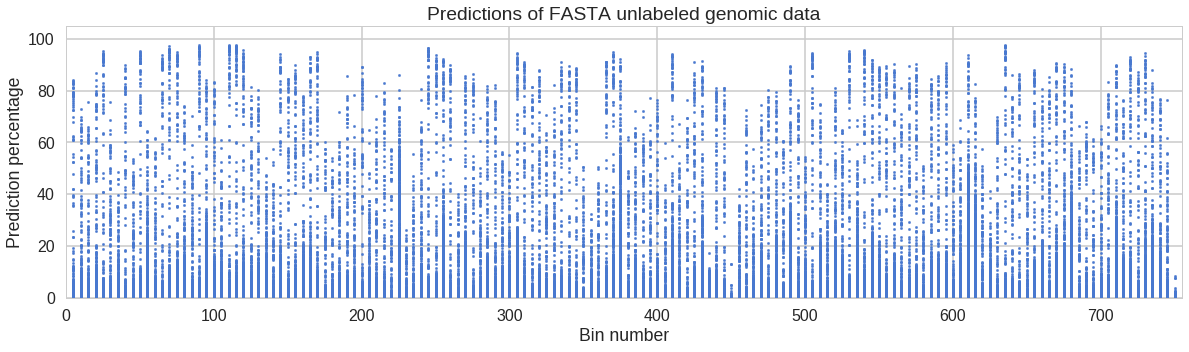

In [18]:
plot_predictions()